## Walnut Creek TDM - OD Summary by Middle Filter

This script takes in Streetlight O-M-D data, summarize the number of OMD trips by Day Type, Time of Day, and Middle Filter.
It outputs heatmaps of OD zones for trips to and from Walnut Creek.

Python 2.7 with Pandas 0.23.4

Input data: 'OMD.csv'


1) Day Type: '0: Average Day (M-Su)', '1: Average Weekday (Tu-Th)', '2: Average Weekend Day (Sa-Sa)'

2) Day Part: '00: All Day (12am-12am)', AM Peak - '08: 7am (7am-8am)', '09: 8am (8am-9am)', PM-Peak - '17: 4pm (4pm-5pm)', '18: 5pm (5pm-6pm)'

3) Middle Filters: 'N Main S of Sunnyvale', 'Treat Blvd @ Walnut Creek', 'Lawrence Way I-680 On Ramp', 'Ygnacio Valley E of I-680', 'California Blvd S of Ygnacio Valley Rd', 'N Main St S of Ygnacio Valley Rd', 'Mt Diablo Blvd E of I-680', 'Olympic Blvd E of I-680', 'Ygnacio Valley @ Walnut Creek Eastern Boundary', 'Treat @ Lime Ridge', 'Civic Dr S of Ygnacio Valley Rd', 'Ygnacio Valley btw Homestead & Montego'

In [4]:
import os
print os.getcwd(); # Prints the working directory
# set working directory
# os.chdir(default_path)

%matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set()

# set comma separator
comma_fmt = FuncFormatter(lambda x, p: format(int(x), ','))

C:\Users\mli\Documents\Scripts\Walnut Creek TDM


In [5]:
# read in O-D Trip Purpose data
omd_df = pd.read_csv('OMD.csv')

In [6]:
list(omd_df) # get a list of attribute names

['Type of Travel',
 'Origin Zone ID',
 'Origin Zone Name',
 'Origin Zone Is Pass-Through',
 'Origin Zone Direction (degrees)',
 'Origin Zone is Bi-Direction',
 'Middle Filter Zone ID',
 'Middle Filter Zone Name',
 'Middle Filter Zone Direction (degrees)',
 'Middle Filter Zone is Bi-Direction',
 'Destination Zone ID',
 'Destination Zone Name',
 'Destination Zone Is Pass-Through',
 'Destination Zone Direction (degrees)',
 'Destination Zone is Bi-Direction',
 'Day Type',
 'Day Part',
 'O-M-D Traffic (StL Index)',
 'Origin Zone Traffic (StL Index)',
 'Middle Filter Zone Traffic (StL Index)',
 'Destination Zone Traffic (StL Index)',
 'OD%',
 'Avg Trip Duration (sec)',
 'Income Less than 20K (percent)',
 'Income 20K to 35K (percent)',
 'Income 35K to 50K (percent)',
 'Income 50K to 75K (percent)',
 'Income 75K to 100K (percent)',
 'Income 100K to 125K (percent)',
 'Income 125K to 150K (percent)',
 'Income 150K to 200K (percent)',
 'Income More than 200K (percent)',
 'No High School Diploma (

In [7]:
# select columns we need
df = omd_df[['Origin Zone ID','Origin Zone Name','Destination Zone ID', 'Middle Filter Zone Name', 'Middle Filter Zone ID', 'Destination Zone Name','Origin Zone Is Pass-Through','Destination Zone Is Pass-Through', 'Day Type', 'Day Part','O-M-D Traffic (StL Index)']]

In [8]:
# read in lookup table
zone = pd.read_csv('zone_crosswalk.csv')

# rename columns
origin_zone = zone.rename(index=str, columns={"ZoneID": "Origin Zone ID","Street Light Zone":"Origin Street Light Zone", "ST Label": "Origin", "Location": "Origin Location", "Group": "Origin Group", "Employment": "Origin Employment"})
destination_zone = zone.rename(index=str, columns={"ZoneID": "Destination Zone ID","Street Light Zone":"Destination Street Light Zone", "ST Label": "Destination", "Location": "Destination Location", "Group": "Destination Group", "Employment": "Destination Employment"})

In [9]:
# join zone lookup table to O-D dataframe
df_o = pd.merge(df, origin_zone, on='Origin Zone ID', validate="many_to_one")
df_od = pd.merge(df_o, destination_zone, on="Destination Zone ID", validate="many_to_one" )

#df_od.head()

In [10]:
# filter out pass-through trips
df_wc= df_od[((df_od['Origin Group'] == 'Walnut Creek') | (df_od['Destination Group'] == 'Walnut Creek')) & (df_od['Origin Zone Is Pass-Through'] == 'no') & (df_od['Destination Zone Is Pass-Through'] == 'no')]
od_wc=df_wc.drop(columns=['Origin Zone Is Pass-Through', 'Destination Zone Is Pass-Through'])
#od_wc.head()

In [11]:
# filter by day part
od_wc_all = od_wc[(od_wc['Day Part'] =='00: All Day (12am-12am)')]
od_wc_am = od_wc[((od_wc['Day Part'] =='08: 7am (7am-8am)')|(od_wc['Day Part'] =='09: 8am (8am-9am)'))]
od_wc_pm = od_wc[((od_wc['Day Part'] =='17: 4pm (4pm-5pm)')|(od_wc['Day Part'] =='18: 5pm (5pm-6pm)'))]

In [12]:
# set group arrays
Day_Type = ['0: Average Day (M-Su)', '1: Average Weekday (Tu-Th)', '2: Average Weekend Day (Sa-Sa)']
Middle_Filter = ['N Main S of Sunnyvale', 'Treat Blvd @ Walnut Creek', 'Lawrence Way I-680 On Ramp', 'Ygnacio Valley E of I-680', 'California Blvd S of Ygnacio Valley Rd', 'N Main St S of Ygnacio Valley Rd', 'Mt Diablo Blvd E of I-680', 'Olympic Blvd E of I-680', 'Ygnacio Valley @ Walnut Creek Eastern Boundary', 'Treat @ Lime Ridge', 'Civic Dr S of Ygnacio Valley Rd', 'Ygnacio Valley btw Homestead & Montego']
# OD = [' Zone Name', ' Location', ' Group']

In [13]:
# loop through and plot
# daily plot
for x in Day_Type:
    od_wc_all_dt = od_wc_all[(od_wc_all['Day Type'] == x)]
    for y in Middle_Filter:
        od_wc_all_mf = od_wc_all_dt[(od_wc_all_dt['Middle Filter Zone Name'] == y)]
#         for z in OD:
            # pivot Table
        matrix = od_wc_all_dt.pivot_table(values= 'O-M-D Traffic (StL Index)', columns= 'Destination', index='Origin', aggfunc=np.sum)
        plt.figure(figsize=(9,9), facecolor='#FFFFFF',edgecolor='#FFFFFF', clear=True)
        plt.title('Daily' + ' ' + x[3:] + ' ' + y, size = 15)
        plot=sns.heatmap(matrix, fmt=".1f", linewidths=.5, square = True, cmap = 'Oranges', annot = None, xticklabels=True, yticklabels=True, vmin=0, vmax=1500,
                cbar_kws={'format':comma_fmt})
        # set text label colors
        for i in range(14):
            plot.get_xticklabels()[i].set_color('grey')
            plot.get_yticklabels()[i].set_color('grey')
    
        for i in range(14, 27):
            plot.get_xticklabels()[i].set_color('#d48686')
            plot.get_yticklabels()[i].set_color('#d48686')
    
        for i in range(27, 38):
            plot.get_xticklabels()[i].set_color('#d990ff')
            plot.get_yticklabels()[i].set_color('#d990ff')
    
        for i in range(38, 44):
            plot.get_xticklabels()[i].set_color('#90b6ff')
            plot.get_yticklabels()[i].set_color('#90b6ff')
                
        plt.savefig('Daily'+ x[3:] + y + '.pdf', dpi=300, bbox_inches='tight', papertype=None)
        plt.close()

In [15]:
# AM plot
for x in Day_Type[:2]:
    od_wc_am_dt = od_wc_am[(od_wc_am['Day Type'] == x)]
    for y in Middle_Filter:
        od_wc_am_mf = od_wc_am_dt[(od_wc_am_dt['Middle Filter Zone Name'] == y)]
#         for z in OD:
            # pivot Table
        matrix = od_wc_am_dt.pivot_table(values= 'O-M-D Traffic (StL Index)', columns= 'Destination', index='Origin', aggfunc=np.sum)
        plt.figure(figsize=(9,9), facecolor='#FFFFFF',edgecolor='#FFFFFF', clear=True)
        plt.title('AM Peak Hour' + ' ' + x[3:] + ' ' + y, size = 15)
        plot=sns.heatmap(matrix, fmt=".1f", linewidths=.5, square = True, cmap = 'Reds', annot = None, xticklabels=True, yticklabels=True, vmin=0, vmax=500,
                cbar_kws={'format':comma_fmt})
        # set text label colors
        for i in range(14):
            plot.get_xticklabels()[i].set_color('grey')
            plot.get_yticklabels()[i].set_color('grey')
    
        for i in range(14, 27):
            plot.get_xticklabels()[i].set_color('#d48686')
            plot.get_yticklabels()[i].set_color('#d48686')
    
        for i in range(27, 38):
            plot.get_xticklabels()[i].set_color('#d990ff')
            plot.get_yticklabels()[i].set_color('#d990ff')
    
        for i in range(38, 44):
            plot.get_xticklabels()[i].set_color('#90b6ff')
            plot.get_yticklabels()[i].set_color('#90b6ff')
                
        plt.savefig('AM'+ x[3:] + y + '.pdf', dpi=300, bbox_inches='tight', papertype=None)
        plt.close()

od_wc_am_dt = od_wc_am[(od_wc_am['Day Type'] == '2: Average Weekend Day (Sa-Sa)')]
for y in Middle_Filter:
    od_wc_am_mf = od_wc_am_dt[(od_wc_am_dt['Middle Filter Zone Name'] == y)]
#         for z in OD:
        # pivot Table
    matrix = od_wc_am_dt.pivot_table(values= 'O-M-D Traffic (StL Index)', columns= 'Destination', index='Origin', aggfunc=np.sum)
    plt.figure(figsize=(9,9), facecolor='#FFFFFF',edgecolor='#FFFFFF', clear=True)
    plt.title('AM Peak Hour' + ' ' + x[3:] + ' ' + y, size = 15)
    plot=sns.heatmap(matrix, fmt=".1f", linewidths=.5, square = True, cmap = 'Reds', annot = None, xticklabels=True, yticklabels=True, vmin=0, vmax=500,
            cbar_kws={'format':comma_fmt})
    # set text label colors
    for i in range(14):
        plot.get_xticklabels()[i].set_color('grey')
        plot.get_yticklabels()[i].set_color('grey')

    for i in range(14, 27):
        plot.get_xticklabels()[i].set_color('#d48686')
        plot.get_yticklabels()[i].set_color('#d48686')

    for i in range(27, 38):
        plot.get_xticklabels()[i].set_color('#d990ff')
        plot.get_yticklabels()[i].set_color('#d990ff')

    for i in range(38, 44):
        plot.get_xticklabels()[i].set_color('#90b6ff')
    for i in range(38, 43):
        plot.get_yticklabels()[i].set_color('#90b6ff')  

    plt.savefig('AM'+ x[3:] + y + '.pdf', dpi=300, bbox_inches='tight', papertype=None)
    plt.close()


IndexError: list index out of range

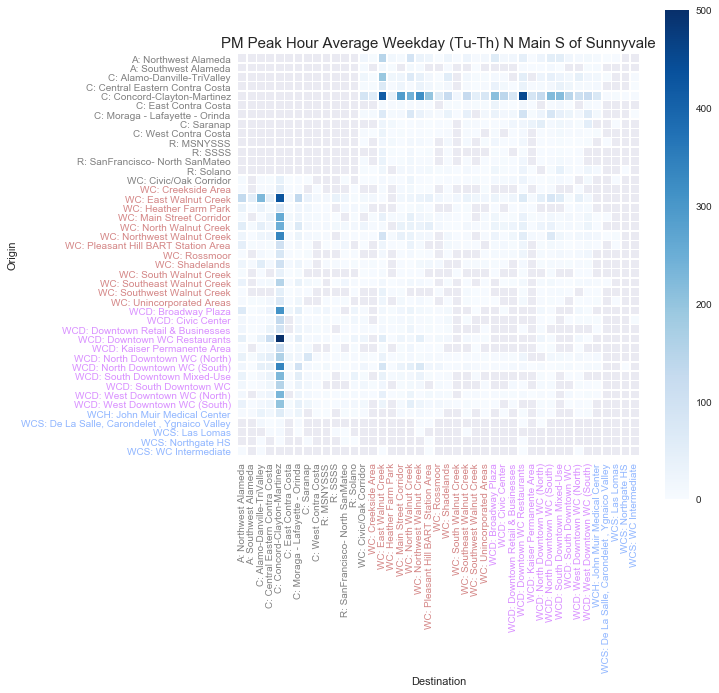

In [16]:
# PM plot
for x in Day_Type[:2]:
    od_wc_pm_dt = od_wc_pm[(od_wc_pm['Day Type'] == x)]
    for y in Middle_Filter:
        od_wc_pm_mf = od_wc_pm_dt[(od_wc_pm_dt['Middle Filter Zone Name'] == y)]
#         for z in OD:
            # pivot Table
        matrix = od_wc_pm_dt.pivot_table(values= 'O-M-D Traffic (StL Index)', columns= 'Destination', index='Origin', aggfunc=np.sum)
        plt.figure(figsize=(9,9), facecolor='#FFFFFF',edgecolor='#FFFFFF', clear=True)
        plt.title('PM Peak Hour' + ' ' + x[3:] + ' ' + y, size = 15)
        plot=sns.heatmap(matrix, fmt=".1f", linewidths=.5, square = True, cmap = 'Reds', annot = None, xticklabels=True, yticklabels=True, vmin=0, vmax=500,
                cbar_kws={'format':comma_fmt})
        # set text label colors
        for i in range(14):
            plot.get_xticklabels()[i].set_color('grey')
            plot.get_yticklabels()[i].set_color('grey')
    
        for i in range(14, 27):
            plot.get_xticklabels()[i].set_color('#d48686')
            plot.get_yticklabels()[i].set_color('#d48686')
    
        for i in range(27, 38):
            plot.get_xticklabels()[i].set_color('#d990ff')
            plot.get_yticklabels()[i].set_color('#d990ff')
    
        for i in range(38, 44):
            plot.get_xticklabels()[i].set_color('#90b6ff')
            plot.get_yticklabels()[i].set_color('#90b6ff')
                
        plt.savefig('PM'+ x[3:] + y + '.pdf', dpi=300, bbox_inches='tight', papertype=None)
        plt.close()

od_wc_pm_dt = od_wc_pm[(od_wc_pm['Day Type'] == '2: Average Weekend Day (Sa-Sa)')]
for y in Middle_Filter:
    od_wc_pm_mf = od_wc_pm_dt[(od_wc_pm_dt['Middle Filter Zone Name'] == y)]
#         for z in OD:
        # pivot Table
    matrix = od_wc_pm_dt.pivot_table(values= 'O-M-D Traffic (StL Index)', columns= 'Destination', index='Origin', aggfunc=np.sum)
    plt.figure(figsize=(9,9), facecolor='#FFFFFF',edgecolor='#FFFFFF', clear=True)
    plt.title('PM Peak Hour' + ' ' + x[3:] + ' ' + y, size = 15)
    plot=sns.heatmap(matrix, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues', annot = None, xticklabels=True, yticklabels=True, vmin=0, vmax=500,
            cbar_kws={'format':comma_fmt})
    # set text label colors
    for i in range(14):
        plot.get_xticklabels()[i].set_color('grey')
        plot.get_yticklabels()[i].set_color('grey')

    for i in range(14, 27):
        plot.get_xticklabels()[i].set_color('#d48686')
        plot.get_yticklabels()[i].set_color('#d48686')

    for i in range(27, 38):
        plot.get_xticklabels()[i].set_color('#d990ff')
        plot.get_yticklabels()[i].set_color('#d990ff')

    for i in range(38, 43):
        plot.get_xticklabels()[i].set_color('#90b6ff')
    for i in range(38, 44):
        plot.get_yticklabels()[i].set_color('#90b6ff')  

    plt.savefig('PM'+ x[3:] + y + '.pdf', dpi=300, bbox_inches='tight', papertype=None)
    plt.close()
